## New York City Yellow Taxi Trip Data in First Quarter of 2019

In this notebook, we extract the raw data from [2019 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2019-Yellow-Taxi-Trip-Data/2upf-qytp) platform. Then, we try to preprocess, clean and analyze the dataset. After we check out the results in **data_analysis.ipynb**, we modify the initial preprocessing codes and apply feature engineering to handle data further. After that, we will feed splitted train/test data to our designed models. Through the cross validation and model selection, we are able to generate desirable outputs for prediction.

In [2]:
import numpy as np
import pandas as pd
import patsy
import seaborn as sns;
import matplotlib.pyplot as plt

from datetime import datetime
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 

sns.set_style('whitegrid')

## Read Data

Similar to the homework about web scraping with Yelp API, we write function to extract the JSON format data from websites. We set right values of limit and offset parameters to get all queried records, and return Pandas dataframe for the conveniece of data preprocessing.

In [2]:
# 2019 Yellow Taxi Trip Data
def extract_data(url, query):
    new_url = url + query
    df = pd.DataFrame()
    
    i = 0
    cur_page = new_url + "&$limit=1000&$offset=" + str(i)
    cur_data = pd.read_json(cur_page)
    while len(cur_data) >= 1000:
        df = df.append(cur_data, sort=True)
        i += 1000
        cur_page = new_url + "&$limit=1000&$offset=" + str(i)
        cur_data = pd.read_json(cur_page)
        
        if i % 4e5 == 0:
            print("{} records have been extracted at {}.".format(i, datetime.now().time()))
    
    if len(cur_data) > 0:
        df = df.append(cur_data, sort=True)
    
    return df

Define functions to save/read data from generated .csv files. For the get data function, it takes around one and half an hour to successfully extract all NYC yellow taxi trip data in the first quarter of 2019.

In [3]:
def save_to_csv(df, fileName="./data/myData.csv"):
    df.to_csv(fileName)

In [4]:
def get_data():
    url = "https://data.cityofnewyork.us/resource/2upf-qytp.json?"
    # pickup time: Jan. ~ June, pickup location: <= 50
    query = "$where=tpep_pickup_datetime between '2019-01-01' and '2019-04-01' and PULocationID<=50"
    query = query.replace(" ", "%20")
    print(url + query)  # first page

    print("Start time: ", datetime.now().time())
    df = extract_data(url, query)
    print("End time: ", datetime.now().time())

    save_to_csv(df)

In [5]:
def read_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    return df

## Data Description

On the NYC Open Data website, there is an [attachment](https://data.cityofnewyork.us/api/views/2upf-qytp/files/4a7a18af-bfc8-43d1-8a2e-faa503f75eb5?download=true&filename=data_dictionary_trip_records_yellow.pdf) that talks about the columns information about the dataset, listed as the following table.


| **Column Name** | **Information** | 
|----------|:-------------|
| VendorID | A code indicating the LPEP provider that provided the record. (1=Creative Mobile Technologies, LLC 2=VeriFone Inc)|
| tpep_pickup_datetime | The date and time when the meter was engaged.|
| tpep_dropoff_datetime | The date and time when the meter was disengaged.|
| Passenger_count| The number of passengers in the vehicle.|
| Trip_distance | The elapsed trip distance in miles reported by the taximeter.|
| PULocationID | TLC Taxi Zone in which the taximeter was engaged|
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged|
| RateCodeID | The final rate code in effect at the end of the trip. (1=Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride)|  
| Payment_type| A numeric code signifying how the passenger paid for the trip. (1=Credit card, 2=Cash 3=No charge, 4=Dispute, 5=Unknown, 6=Voided trip)|
| Fare_amount | The time-and-distance fare calculated by the meter.|
|Extra | Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1.0 rush hour and overnight charges.|
| MTA_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use.|
| Improvement_surcharge | \$0.30 improvement surcharge assessed on hailed trips at the flag drop.|
| Tip amount | This field is automatically populated for credit card tips. Cash tips are not included.|
| Tolls_amount | Total amount of all tolls paid in trip.|
| Total_amount | The total amount charged to passengers. Does not include cash tips.|

## Data Cleaning

For the initial stage of data cleaning, we define several functions to preprocess the raw dataset. Afterwards we will use the output "myData.csv" to do data analysis, in seek of some data insights about what model we could possibly utilize in the next step.

In [6]:
def drop_useless_columns(df):
    # get rid of useless columns
    df = df.drop(columns=["congestion_surcharge", "store_and_fwd_flag"])
    return df

In [7]:
def convert_to_timestamp(df):
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
    return df

In [8]:
def create_duration_colum(df):
    # create "duration" column from pickup and dropoff datetime
    df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    
    # convert to minutes
    df["duration"] = df['duration'].dt.total_seconds() / 60
    return df

All the generated data are stored in the "./data/" directory. Consider the size of .csv files is too large, we git ignore *.csv files when we push to the repo.

In [9]:
path = "./data/myData.csv"
df = read_from_csv(path)
df = drop_useless_columns(df)
df = convert_to_timestamp(df)
df = create_duration_colum(df)

df.columns

/usr/local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['dolocationid', 'extra', 'fare_amount', 'improvement_surcharge',
       'mta_tax', 'passenger_count', 'payment_type', 'pulocationid',
       'ratecodeid', 'tip_amount', 'tolls_amount', 'total_amount',
       'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'trip_distance',
       'vendorid', 'duration'],
      dtype='object')

In [10]:
df.head(10)

,dolocationid,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pulocationid,ratecodeid,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid,duration
0,1,0.0,20.0,0.3,0.5,1,1,1,5,1.00,0.00,21.80,2019-01-01 02:19:32,2019-01-01 02:19:27,0.0,2,0.083333
1,1,0.0,85.0,0.3,0.0,1,1,1,5,2.00,0.00,87.30,2019-01-01 05:52:53,2019-01-01 05:52:45,0.0,2,0.133333
2,1,0.0,80.0,0.3,0.0,1,1,1,5,0.00,0.00,80.30,2019-01-01 06:23:23,2019-01-01 06:22:24,0.0,2,0.983333
3,1,0.0,80.0,0.3,0.0,2,1,1,5,16.06,0.00,96.36,2019-01-01 08:13:01,2019-01-01 08:12:51,0.0,2,0.166667
4,1,0.0,160.0,0.3,0.5,2,1,1,5,0.00,0.00,160.80,2019-01-01 08:14:53,2019-01-01 08:14:48,0.0,2,0.083333
5,1,0.0,2.5,0.3,0.5,3,2,1,1,0.00,0.00,3.30,2019-01-01 10:10:33,2019-01-01 10:10:30,16.9,1,0.050000
6,1,0.0,0.0,0.3,0.0,3,3,1,5,0.00,16.26,16.56,2019-01-01 10:11:32,2019-01-01 10:10:52,16.9,1,0.666667
7,1,0.0,0.0,0.3,0.0,3,3,1,5,0.00,16.26,16.56,2019-01-01 10:13:13,2019-01-01 10:12:05,16.9,1,1.133333
8,1,0.0,120.0,0.3,0.0,3,2,1,5,0.00,16.26,136.56,2019-01-01 10:14:35,2019-01-01 10:13:44,16.9,1,0.850000
9,1,0.0,90.0,0.3,0.0,3,1,1,5,18.06,0.00,108.36,2019-01-01 12:16:23,2019-01-01 12:16:18,0.0,2,0.083333


In [11]:
# save_to_csv(df, "./data/processed_myData.csv")
len(df)

1838913

After the exploration and analysis of the column features and data distribution, we modify the original preprocessing methods. This will remove more data points (known as outliers or bad, ignorable rows) to make the whole dataset consistent and well-distributed.

In [12]:
def drop_outliers(df):
    # drop rows with 0.0 total amount or 0.0 trip distance
    df = df[(df['total_amount'] > 0.0) & (df['trip_distance'] > 0.0)]
    
    # trip duration should be less than or equal to 40 minutes
    df = df[df['duration'] <= 90]
    
    # count of passengers should be positive and less than 5
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 4)]
    
    # trip distance between 1 and 20 miles
    df = df[(df['trip_distance'] >= 1.) & (df['trip_distance'] <= 20)]
    
    # only reserve standard code trip
    df = df[df['ratecodeid'] == 1]
    
    # get rid of payment type that is "dispute" or "no charge"
    df = df[(df['payment_type'] == 1) | (df['payment_type'] == 2)]
    
    df = df.dropna().reset_index(drop=True)
    return df

In [13]:
df = drop_outliers(df)
len(df)

1196085

In [14]:
df.head(10)

,dolocationid,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pulocationid,ratecodeid,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,vendorid,duration
0,1,0.0,2.5,0.3,0.5,3,2,1,1,0.00,0.0,3.30,2019-01-01 10:10:33,2019-01-01 10:10:30,16.90,1,0.050000
1,265,0.0,24.5,0.3,0.5,1,2,1,1,0.00,0.0,25.30,2019-01-02 15:11:48,2019-01-02 14:50:55,7.92,2,20.883333
2,249,1.0,41.0,0.3,0.5,1,2,1,1,0.00,17.5,60.30,2019-01-09 17:23:39,2019-01-09 16:55:48,14.97,2,27.850000
3,237,1.0,8.5,0.3,0.5,1,1,1,1,1.00,0.0,11.30,2019-01-09 19:23:18,2019-01-09 19:13:21,2.01,2,9.950000
4,265,0.0,7.5,0.3,0.5,1,1,1,1,1.66,0.0,9.96,2019-01-11 07:52:27,2019-01-11 07:43:43,1.04,2,8.733333
5,1,1.0,2.5,0.3,0.5,4,1,1,1,39.00,0.0,43.30,2019-01-11 17:37:53,2019-01-11 17:37:51,14.60,1,0.033333
6,1,0.0,13.0,0.3,0.5,1,2,1,1,0.00,0.0,13.80,2019-01-16 15:11:33,2019-01-16 14:59:21,3.31,2,12.200000
7,265,0.0,38.5,0.3,0.5,1,2,1,1,0.00,0.0,39.30,2019-01-22 10:10:52,2019-01-22 09:32:00,11.20,1,38.866667
8,1,1.0,2.5,0.3,0.5,1,2,1,1,0.00,0.0,4.30,2019-01-25 16:35:23,2019-01-25 16:35:18,17.40,1,0.083333
9,1,1.0,2.5,0.3,0.5,1,2,1,1,0.00,0.0,4.30,2019-01-25 16:37:27,2019-01-25 16:37:23,17.40,1,0.066667


## Feature Engineering

### Add Time Related Features

In [16]:
# indicating which hour in the day of pickup time, int [0-23]
df["hour_of_day"] = df.tpep_dropoff_datetime.dt.hour

# indicating which day in the week, 0: Sunday, 1: Monday, 2: Tuesday, 3: Wednesday， 4: Thursday, 5: Friday, 6: Satureday
df["day_of_week"] = df.tpep_dropoff_datetime.dt.weekday

# indicating which day in the month, an integer from 1 to 30 or 31
df["day_of_month"] = df.tpep_dropoff_datetime.dt.day

# indicating which week in the year
df["week_of_year"] = df.tpep_dropoff_datetime.dt.weekofyear

# tip proportion of total amount 
df['tip_proportion'] = df.tip_amount / df.total_amount

### Correlation between features

In [17]:
# drop all 1 column "ratecodeid" and datetime columns
new_df = df.drop(columns=["tpep_dropoff_datetime", "tpep_pickup_datetime", "ratecodeid"])

In [18]:
columns = new_df.columns.tolist()
columns.remove("duration")
features = "+".join(columns)
target = "duration"
print(features)

y, X = patsy.dmatrices(target + '~' + features, new_df, return_type='dataframe')
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.T

vif

dolocationid+extra+fare_amount+improvement_surcharge+mta_tax+passenger_count+payment_type+pulocationid+tip_amount+tolls_amount+total_amount+trip_distance+vendorid+hour_of_day+day_of_week+day_of_month+week_of_year+tip_proportion


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Features,Intercept,dolocationid,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pulocationid,tip_amount,tolls_amount,total_amount,trip_distance,vendorid,hour_of_day,day_of_week,day_of_month,week_of_year,tip_proportion
VIF Factor,25398.9,1.01945,2.7024,107.897,1.0002,1.00043,1.00669,3.13598,1.06015,13.7417,2.57785,143.492,11.6424,2.02698,1.04955,1.01223,1.2585,2.4205,7.04265


From above VIF score for each feature, we noticed that "fare_amount", "total_amount" have relatively high VIF score, which indicates they may have high correlation. Next we check the pearson score between each pair of feature.

In [19]:
pearson_correlation = new_df.corr(method ='pearson')
pearson_correlation

,dolocationid,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pulocationid,tip_amount,tolls_amount,total_amount,trip_distance,vendorid,duration,hour_of_day,day_of_week,day_of_month,week_of_year,tip_proportion
dolocationid,1.000000,0.030562,-0.067529,-0.000462,-0.000984,0.000849,-0.040293,0.037537,0.014940,-0.039101,-0.046616,-0.071961,-0.004124,-0.055944,0.028560,-0.016457,-0.001781,-0.008667,0.060007
extra,0.030562,1.000000,-0.004069,0.006355,-0.009505,-0.018776,-0.034741,0.040610,0.071660,-0.017923,0.083215,-0.007761,-0.617238,0.003006,0.120817,-0.038477,0.002965,0.305399,0.040822
fare_amount,-0.067529,-0.004069,1.000000,0.000209,-0.001024,0.001528,-0.049163,-0.158364,0.366933,0.410040,0.954541,0.952468,0.006156,0.894493,-0.033905,-0.014345,0.010188,0.032665,-0.050734
improvement_surcharge,-0.000462,0.006355,0.000209,1.000000,0.002705,0.001922,-0.009543,0.000009,0.004659,0.000334,0.001892,0.000224,-0.004879,-0.008648,0.000103,0.000553,0.000839,-0.000928,0.006000
mta_tax,-0.000984,-0.009505,-0.001024,0.002705,1.000000,0.003659,0.001540,-0.000750,-0.005967,-0.004812,-0.001975,-0.001537,0.013758,-0.000113,0.002647,0.000484,0.002071,-0.000657,-0.003692
passenger_count,0.000849,-0.018776,0.001528,0.001922,0.003659,1.000000,0.035606,0.014100,-0.014333,-0.002858,-0.000148,-0.001496,0.039473,0.007309,0.032489,0.044392,-0.006332,-0.000396,-0.022120
payment_type,-0.040293,-0.034741,-0.049163,-0.009543,0.001540,0.035606,1.000000,0.040799,-0.601191,-0.033930,-0.192582,-0.050696,0.009175,-0.037760,-0.035080,0.026214,-0.014440,-0.022278,-0.808965
pulocationid,0.037537,0.040610,-0.158364,0.000009,-0.000750,0.014100,0.040799,1.000000,-0.075476,-0.037990,-0.141320,-0.184155,-0.004318,-0.091827,0.017442,0.024397,-0.004043,-0.000195,-0.003273
tip_amount,0.014940,0.071660,0.366933,0.004659,-0.005967,-0.014333,-0.601191,-0.075476,1.000000,0.210210,0.580407,0.355262,0.000367,0.321214,0.029028,-0.023226,0.014111,0.073193,0.772787
tolls_amount,-0.039101,-0.017923,0.410040,0.000334,-0.004812,-0.002858,-0.033930,-0.037990,0.210210,1.000000,0.484760,0.449542,0.010973,0.275437,-0.013915,-0.012144,0.006024,0.010392,-0.006584


(19.5, -0.5)

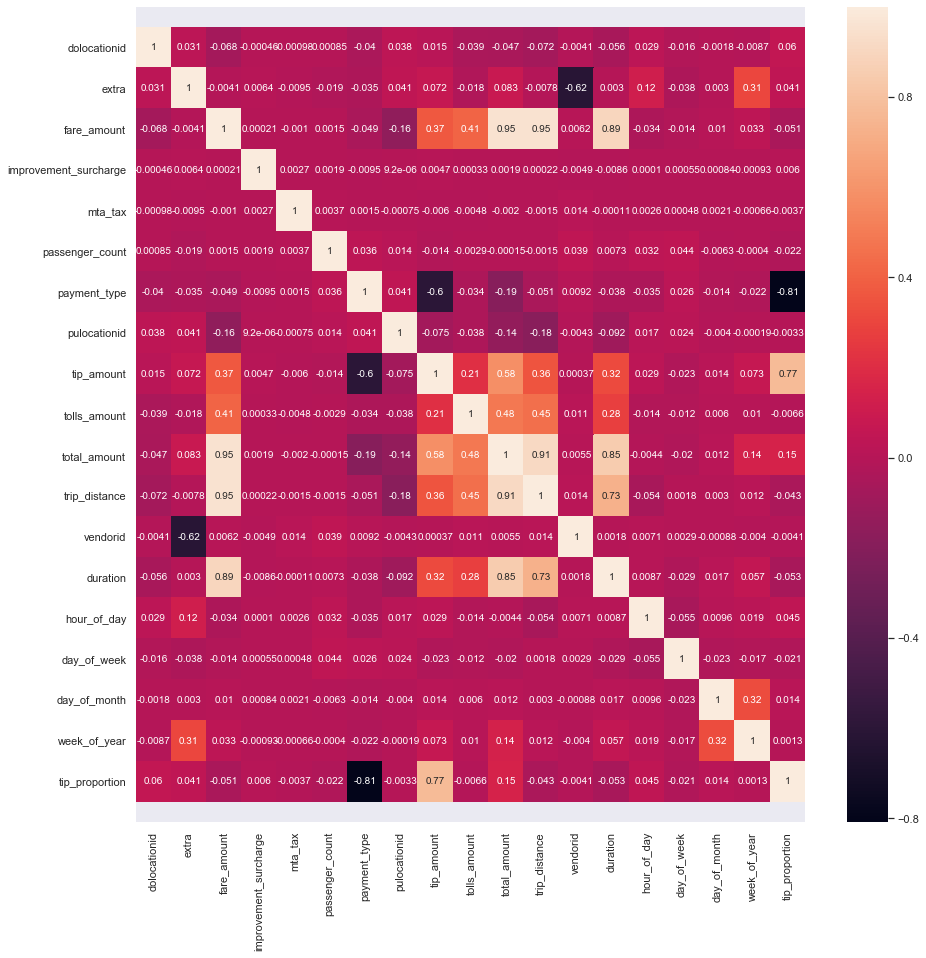

In [20]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(pearson_correlation,
            xticklabels=pearson_correlation.columns,
            yticklabels=pearson_correlation.columns,
            annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

We noticed that "trip_distance", "total_amount" and "fare_amount" have high correlation with each other. So we drop two of them to prevent from collinearity.

In [ ]:
df = df.drop(columns=["trip_distance", "total_amount"])

In [24]:
df.head(10)

,dolocationid,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pulocationid,ratecodeid,tip_amount,tolls_amount,tpep_dropoff_datetime,tpep_pickup_datetime,vendorid,duration,hour_of_day,day_of_week,day_of_month,week_of_year,tip_proportion
0,1,0.0,2.5,0.3,0.5,3,2,1,1,0.00,0.0,2019-01-01 10:10:33,2019-01-01 10:10:30,1,0.050000,10,1,1,1,0.000000
1,265,0.0,24.5,0.3,0.5,1,2,1,1,0.00,0.0,2019-01-02 15:11:48,2019-01-02 14:50:55,2,20.883333,15,2,2,1,0.000000
2,249,1.0,41.0,0.3,0.5,1,2,1,1,0.00,17.5,2019-01-09 17:23:39,2019-01-09 16:55:48,2,27.850000,17,2,9,2,0.000000
3,237,1.0,8.5,0.3,0.5,1,1,1,1,1.00,0.0,2019-01-09 19:23:18,2019-01-09 19:13:21,2,9.950000,19,2,9,2,0.088496
4,265,0.0,7.5,0.3,0.5,1,1,1,1,1.66,0.0,2019-01-11 07:52:27,2019-01-11 07:43:43,2,8.733333,7,4,11,2,0.166667
5,1,1.0,2.5,0.3,0.5,4,1,1,1,39.00,0.0,2019-01-11 17:37:53,2019-01-11 17:37:51,1,0.033333,17,4,11,2,0.900693
6,1,0.0,13.0,0.3,0.5,1,2,1,1,0.00,0.0,2019-01-16 15:11:33,2019-01-16 14:59:21,2,12.200000,15,2,16,3,0.000000
7,265,0.0,38.5,0.3,0.5,1,2,1,1,0.00,0.0,2019-01-22 10:10:52,2019-01-22 09:32:00,1,38.866667,10,1,22,4,0.000000
8,1,1.0,2.5,0.3,0.5,1,2,1,1,0.00,0.0,2019-01-25 16:35:23,2019-01-25 16:35:18,1,0.083333,16,4,25,4,0.000000
9,1,1.0,2.5,0.3,0.5,1,2,1,1,0.00,0.0,2019-01-25 16:37:27,2019-01-25 16:37:23,1,0.066667,16,4,25,4,0.000000


## Data Split

After the feature engineering step, we split the processed dataframe to train set and test set two parts. In the **model.ipynb**, we will use the split data for validation and model selection.

In [25]:
X_train, X_test = train_test_split(df, test_size=0.2)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print("Train size: {}".format(len(X_train)))
print("Test size: {}".format(len(X_test)))

Train size: 956868
Test size: 239217


In [26]:
save_to_csv(X_train, "./data/train.csv")
save_to_csv(X_test, "./data/test.csv")